# 간단히 모델 별 성능 비교하기
별다른 튜닝없이 기본값으로 모델 간의 성능을 간략히 비교해보려고 한다.

scikit-learn 라이브러리에 내장된 boston 데이터셋(회귀문제)를 가지고 비교해보았으며,   
아래 결과는 라이브러리에 설정된 파라미터 기본값이 우연히 데이터셋에 잘 맞거나 안 맞아서 나타나는 차이일 수 있으므로 맹신하지 말고 참고 정도만 하자.

## 1. EDA
데이터를 불러오고 타겟과의 관계를 시각화해본다

In [1]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True) # sklearn에 내장된 boston house price 데이터셋
print(X.shape) # 13개의 특성을 가진 506개의 데이터셋
print(y.shape) # 506개의 타겟(price 값)

(506, 13)
(506,)


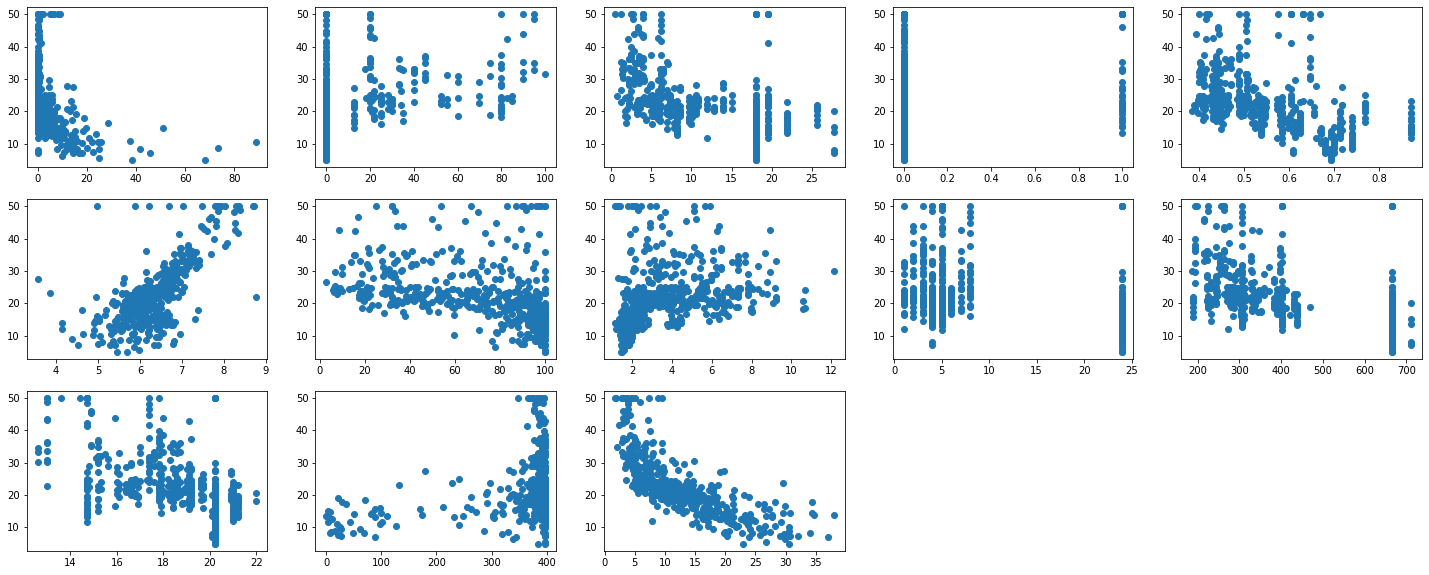

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10)) # 그래프 크기를 보기좋게

for index, x in enumerate(X.transpose()): # 각 특성들과 타겟의 관계 시각화
    plt.subplot(3, 5, index+1)
    plt.scatter(X[:, index], y)

## 2. Split datasets and Preprocess
train, test 셋으로 나누고 `StandardScaler`로 스케일링해준다.   
이때 먼저 데이터셋을 나누고 스케일러를 train에 `fit`한 후 test에서는 `transform`만 하는 것이 중요하다.   
데이터누출(data leakage)를 방지하기 위함이며 자세한 것은 아래 링크를 참고하자.   
https://machinelearningmastery.com/data-preparation-without-data-leakage/

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train.shape, X_test.shape

((379, 13), (127, 13))

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 3. Define Functions
모델을 만들기와 `fit`, `score`를 프린트하는 것까지 하나의 함수로 만든다. (반복을 줄이기위해. 필수아님)

In [5]:
from sklearn.metrics import mean_absolute_error

def make_and_train(*args):
    models = {}
    for model in args:
        m = model()
        m.fit(X_train_scaled, y_train)
        models[str(m)] = m
    return models

def print_scores(models: dict):
    print(f'*** MAE scores ***      train, test')
    print(f'-----------------------------------')
    for k, v in models.items():
        y_pred_1 = v.predict(X_train_scaled)
        score_1 = mean_absolute_error(y_train, y_pred_1)
        y_pred_2 = v.predict(X_test_scaled)
        score_2 = mean_absolute_error(y_test, y_pred_2)
        print(f"{k:30}: {score_1:.2f}  {score_2:.2f}")
    print('')

def do_all(*args):
    print_scores(make_and_train(*args))

## 4. Results

In [6]:
# Linear Regressions
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso

do_all(DummyRegressor, LinearRegression, Ridge, Lasso)

# Tree Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

do_all(DecisionTreeRegressor, RandomForestRegressor)

# Ensembles
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor
do_all(AdaBoostRegressor, GradientBoostingRegressor)

# SVMs
from sklearn.svm import SVR, LinearSVR, NuSVR

do_all(SVR, LinearSVR, NuSVR)

*** MAE scores ***      train, test
-----------------------------------
DummyRegressor()              : 6.89  6.22
LinearRegression()            : 3.37  3.06
Ridge()                       : 3.36  3.06
Lasso()                       : 3.72  3.51

*** MAE scores ***      train, test
-----------------------------------
DecisionTreeRegressor()       : 0.00  2.55
RandomForestRegressor()       : 0.89  2.13

*** MAE scores ***      train, test
-----------------------------------
AdaBoostRegressor()           : 2.27  2.73
GradientBoostingRegressor()   : 1.07  2.02

*** MAE scores ***      train, test
-----------------------------------
SVR()                         : 3.04  2.77
LinearSVR()                   : 3.14  3.12
NuSVR()                       : 3.24  2.87



## 5. TensorFlow로도 한번 해보았다

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nn = Sequential([
    Dense(32, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

nn.compile(optimizer='adam', loss='mean_absolute_error')
history = nn.fit(X_train_scaled, y_train, epochs=100, validation_data=(X_test_scaled, y_test), verbose=0)

In [8]:
train_score, test_score = history.history['loss'][-1], history.history['val_loss'][-1]

print("MAE train, test\n-----------------")
print(f"{train_score:8.2f} {test_score:6.2f}")

MAE train, test
-----------------
    2.09   2.16


## 6. 결론
Toy Dataset (Boston Housing)을 이용한 Regression 문제를 풀어봤을 때, 별도의 튜닝을 거치지 않은 기본값을 기준으로 성능이 가장 좋은 것은 `GradientBoosting` 모델이었다. 그 뒤를 이어 `RandomForest` 모델도 나쁘지 않았으며, LinearRegression 모델들은 예상대로 별로였다. TensorFlow를 이용한 모델도 성능은 좋았으나 에폭 100번을 돌린거라 학습시간 대비 효율은 좋지 않다고 볼 수 있다. 딥러닝이 역사적으로 긴 겨울을 보낸 이유를 알 것 같다. Tabular Data 성격을 띈 데이터셋이라면 일반 머신러닝 모델을 활용하는 것이 효율적일 것 같다.

### 추후 시도해볼 것
- 분류 문제에서는 어떨까
- 스케일러를 바꿔보면 어떨까
- 튜닝을 했을 때는 무엇이 좋을까